# EMU and DES tile distribution and coverage

## Libraries

In [ ]:
import pandas as pd

import numpy as np

from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u

from bs4 import BeautifulSoup

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as mplPolygon

from shapely.geometry import Polygon as splyPolygon
from shapely.geometry import MultiPolygon
from shapely.ops import unary_union

import numpy as np

## Load EMU html file

In [ ]:
# Load the HTML file

filename = '/home/polaris/Lab_Astro/data/EMU_data/EMU_tiles_full.html'
with open(filename, 'r', encoding='utf-8') as file:
    html_content = file.read()

# Parse the HTML content using BeautifulSoup
soup = BeautifulSoup(html_content, 'html.parser')

# Find the table in the HTML (assuming there's only one table)
table = soup.find('table')

# Extract table headers (if any)
headers = []
for th in table.find_all('th'):
    headers.append(th.text.strip())

# Extract table rows
rows = []
for tr in table.find_all('tr'):
    cells = tr.find_all('td')
    if len(cells) > 0:
        row = [cell.text.strip() for cell in cells]
        rows.append(row)

# Convert the table data into a pandas DataFrame
emu_tiles_df = pd.DataFrame(rows, columns=headers)
emu_tiles_df.head()

Convert the RA in hh:mm:ss and DEC in dd:mm:ss to degrees and save result sin new columns ra_deg; dec_deg

In [ ]:
ra_hms = emu_tiles_df['ra'].values  # Extract RA values as a NumPy array
dec_dms = emu_tiles_df['dec'].values # Extract Dec values as a NumPy array

# Create a SkyCoord object directly from the arrays
coord = SkyCoord(ra=ra_hms, dec=dec_dms, unit=(u.hourangle, u.deg))

# Access the converted RA and Dec values in degrees
emu_tiles_df['ra_deg'] = coord.ra.deg
emu_tiles_df['dec_deg'] = coord.dec.deg

# Print the updated DataFrame
emu_tiles_df.head()

,field_name,ra,dec,pa,sbid,observe_date,obs_length,release_date,ra_deg,dec_deg
0,EMU_0000-37,00:00:00.000,-37:14:54.564,0.0,,,,,0.0,-37.248490
1,EMU_0000-60,00:00:00.000,-60:19:18.170,0.0,,,,,0.0,-60.321714
2,EMU_0000-64,00:00:00.000,-64:54:13.165,0.0,60335,2024-03-25T01:21:14,10.01,2024-04-29T01:16:33,0.0,-64.903657
3,EMU_0000-73,00:00:00.000,-73:39:49.072,0.0,70462,2025-01-28T04:48:50,10.0,2025-02-06T02:27:00,0.0,-73.663631
4,EMU_0000-83,00:00:00.000,-82:59:26.354,0.0,,,,,0.0,-82.990654


In [99]:
# prompt: convert sbid column to integer type and obs_length column to float type

# Convert 'sbid' column to integer type
emu_tiles_df['sbid'] = pd.to_numeric(emu_tiles_df['sbid'], errors='coerce').astype('Int64')

# Convert 'obs_length' column to float type
emu_tiles_df['obs_length'] = pd.to_numeric(emu_tiles_df['obs_length'], errors='coerce').astype('float')


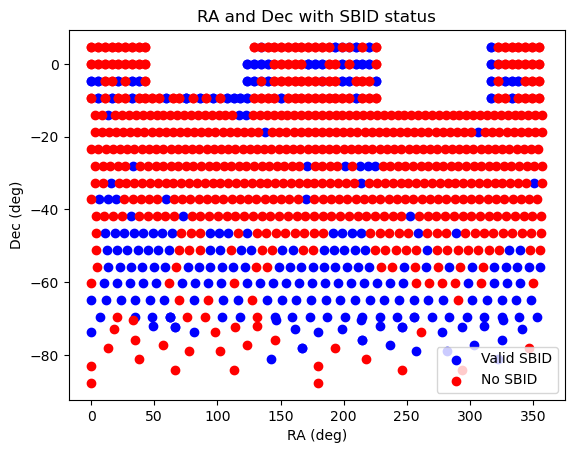

In [ ]:
# prompt: plot ra_deg, dec_deg using different colors for those that have valid sbid

# Assuming 'sbid' is the column with SBID information
has_sbid = emu_tiles_df['sbid'].notna()

# Plot points with different colors based on whether 'sbid' is valid
plt.scatter(emu_tiles_df.loc[has_sbid, 'ra_deg'], emu_tiles_df.loc[has_sbid, 'dec_deg'], color='blue', label='Valid SBID')
plt.scatter(emu_tiles_df.loc[~has_sbid, 'ra_deg'], emu_tiles_df.loc[~has_sbid, 'dec_deg'], color='red', label='No SBID')

plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.title('Center of EMU Tiles with SBID Information')
plt.legend()
plt.show()

## Plot the actual tiles around the centers for EMU

In [176]:
# polygons for area analysis
emu_tiles_deg = []
emu_tiles_rad = []

# polygons for plotting in degrees and radians
emu_tiles_plot_deg = []
emu_tiles_plot_rad = []

# polygons with valid tiles for plotting in radians
emu_tiles_plot_rad_valid = []

for i in range(len(emu_tiles_df)):
    ra_deg = emu_tiles_df['ra_deg'][i]
    dec_deg = emu_tiles_df['dec_deg'][i]
    
    # Size of the tile in degrees
    size = 5 
    half_size = size / 2

    # Define the corners of the tile in degrees
    corners_deg = [
        (ra_deg - half_size, dec_deg - half_size),
        (ra_deg + half_size, dec_deg - half_size),
        (ra_deg + half_size, dec_deg + half_size),
        (ra_deg - half_size, dec_deg + half_size)
    ]

    # Shift RA values to center the plot at RA = 0 and convert to radians
    corners_rad = [(  np.radians(ra - 360 if ra > 180 else ra ), np.radians(dec)) for ra, dec in corners_deg]

    # Define the color of the tiles, if the SBID is missing, color it red, if not, color it blue
    color = 'red' if pd.isna(emu_tiles_df['sbid'][i]) else 'blue'

    # Append to lists
    emu_tiles_deg.append(splyPolygon(corners_deg))
    emu_tiles_rad.append(splyPolygon(corners_rad))
    if color == 'blue':
        emu_tiles_plot_rad_valid.append(mplPolygon(corners_rad))
    emu_tiles_plot_deg.append(mplPolygon(corners_deg, closed=True, edgecolor=color, facecolor='none'))
    emu_tiles_plot_rad.append(mplPolygon(corners_rad, closed=True, edgecolor=color, facecolor='none'))


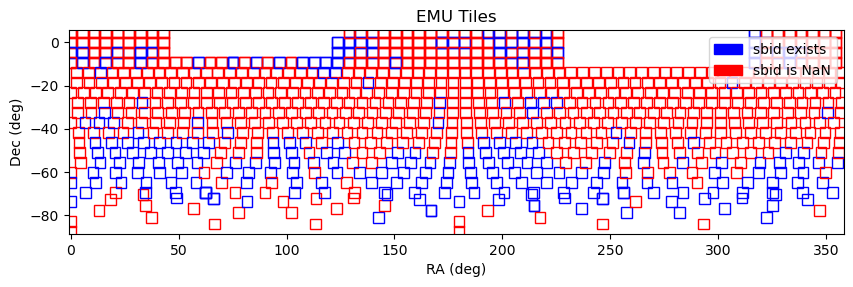

In [160]:
# WARNING: Need to run the code block above before running this code block

# Plot EMU tiles in degrees in flat square projection
plt.figure(figsize=(10, 8))
for i in range(len(emu_tiles_plot_deg)):
    plt.gca().add_patch(emu_tiles_plot_deg[i])

# Add legend
blue_patch = mpatches.Patch(color='blue', label='sbid exists')
red_patch = mpatches.Patch(color='red', label='sbid is NaN')
plt.legend(handles=[blue_patch, red_patch], loc='upper right')

# Set plot labels and title
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.title('EMU Tiles')
plt.xlim(emu_tiles_df['ra_deg'].min() - 1, emu_tiles_df['ra_deg'].max() + 1)
plt.ylim(emu_tiles_df['dec_deg'].min() - 1, emu_tiles_df['dec_deg'].max() + 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

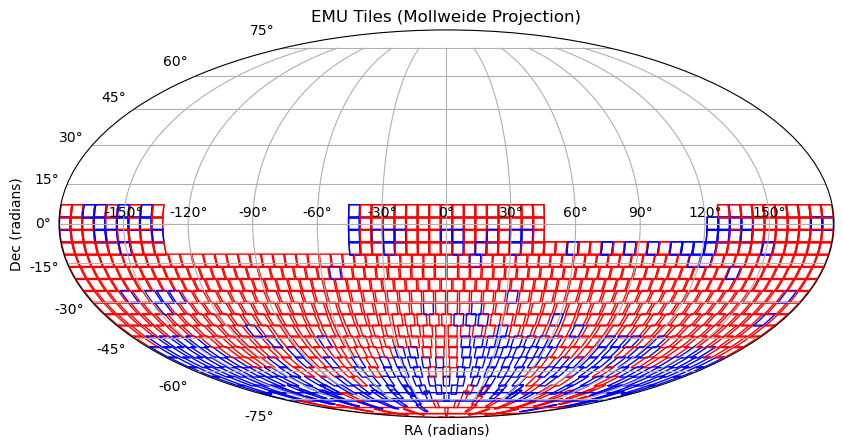

In [167]:
# Create a Mollweide projection plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='mollweide')

# Plot EMU tiles in radians in Mollweide projection
for i in range(len(emu_tiles_plot_rad)):
    plt.gca().add_patch(emu_tiles_plot_rad[i])

# Set plot labels and title
ax.set_xlabel('RA (radians)')
ax.set_ylabel('Dec (radians)')
ax.set_title('EMU Tiles (Mollweide Projection)')
ax.grid(True)

# Show the plot
plt.show()

## Plot the DES DR1 tiles

In [87]:
des_tiles_path = '/home/polaris/Lab_Astro/data/des_dr1.tile_info.fits'

with fits.open(des_tiles_path) as hdul:
    des_tiles_data = hdul[1].data

des_tiles_df = pd.DataFrame(des_tiles_data)

In [146]:
# create a list of DES DR1 tiles

des_tiles_deg = []
des_tiles_rad = []
des_tiles_plot_deg = []
des_tiles_plot_rad = []

for i in range(len(des_tiles_df)):

    corners_deg = [
        (des_tiles_df['rac1'][i],des_tiles_df['decc1'][i]),
        (des_tiles_df['rac2'][i],des_tiles_df['decc2'][i]),
        (des_tiles_df['rac3'][i],des_tiles_df['decc3'][i]),
        (des_tiles_df['rac4'][i],des_tiles_df['decc4'][i])
    ]

    # Shift RA values to center the plot at RA = 0 and convert to radians
    corners_rad = [(  np.radians(ra - 360 if ra > 180 else ra ), np.radians(dec)) for ra, dec in corners_deg]

    # Append to lists
    des_tiles_deg.append(splyPolygon(corners_deg))
    des_tiles_rad.append(splyPolygon(corners_rad))
    des_tiles_plot_deg.append(mplPolygon(corners_deg, closed=True, edgecolor='purple', facecolor='none'))
    des_tiles_plot_rad.append(mplPolygon(corners_rad, closed=True, edgecolor='purple', facecolor='none'))

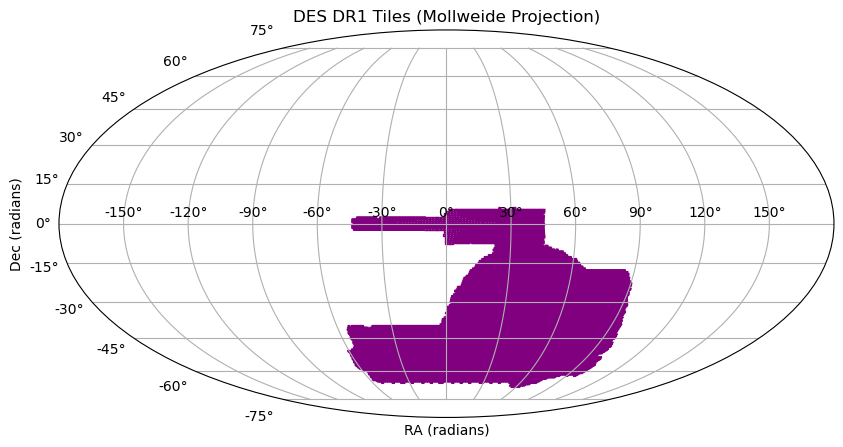

In [135]:
# Create a Mollweide projection plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='mollweide')

# Plot EMU tiles in radians in Mollweide projection
for i in range(len(des_tiles_plot_rad)):
    plt.gca().add_patch(des_tiles_plot_rad[i])

# Set plot labels and title
ax.set_xlabel('RA (radians)')
ax.set_ylabel('Dec (radians)')
ax.set_title('DES DR1 Tiles (Mollweide Projection)')
ax.grid(True)

# Show the plot
plt.show()

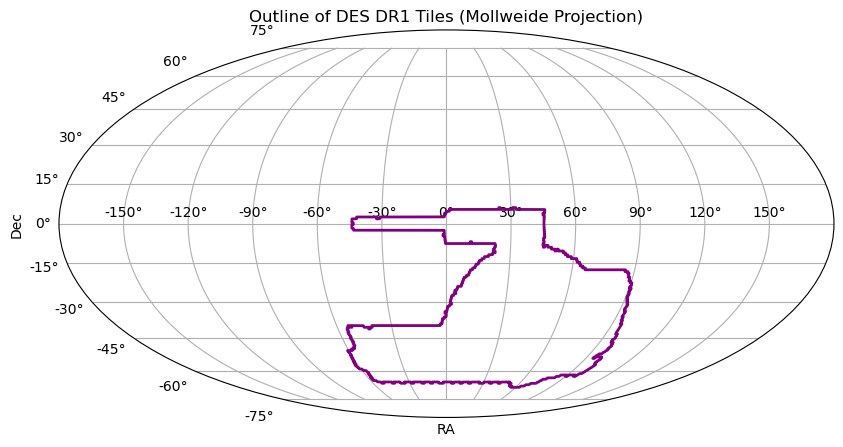

In [163]:
all_tiles = MultiPolygon(des_tiles_rad)

outline = unary_union(all_tiles)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='mollweide')

for geom in outline.geoms if hasattr(outline, 'geoms') else [outline]:
    ra, dec = geom.exterior.xy
    ax.plot(ra, dec, color='purple', linewidth=2)

ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.set_title('Outline of DES DR1 Tiles (Mollweide Projection)')
ax.grid(True)

plt.show()

## Check for overlap of the DES tiles on EMU

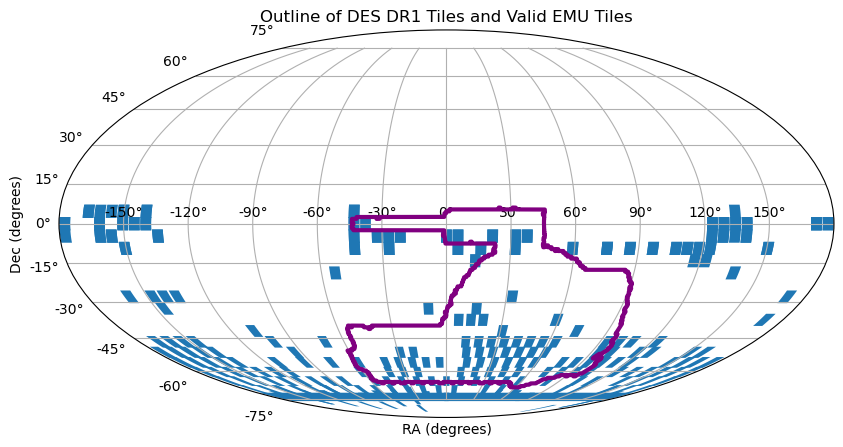

In [177]:
all_tiles = MultiPolygon(des_tiles_rad)

outline = unary_union(all_tiles)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='mollweide')

# Plot the outline of the DES DR1 tiles
for geom in outline.geoms if hasattr(outline, 'geoms') else [outline]:
    ra, dec = geom.exterior.xy
    ax.plot(ra, dec, color='purple', linewidth=3)

# Plot the valid EMU tiles
for i in range(len(emu_tiles_plot_rad_valid)):
    plt.gca().add_patch(emu_tiles_plot_rad_valid[i])

ax.set_xlabel('RA (degrees)')
ax.set_ylabel('Dec (degrees)')
ax.set_title('Outline of DES DR1 Tiles and Valid EMU Tiles')
ax.grid(True)

plt.show()


In [ ]:
# Plot valid EMU tiles and and Outline of DES DR1 tiles
all_tiles = MultiPolygon(des_tiles_rad)

outline = unary_union(all_tiles)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='mollweide')

for geom in outline.geoms if hasattr(outline, 'geoms') else [outline]:
    ra, dec = geom.exterior.xy
    ax.plot(ra, dec, color='purple', linewidth=1)

ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.set_title('Outline of DES DR1 Tiles (Mollweide Projection)')
ax.grid(True)
 

In [80]:
def check_polygon_overlap(primary_polygons, secondary_polygons):
    for primary in primary_polygons:
        for secondary in secondary_polygons:
            if primary.intersects(secondary):  # Check if the polygons overlap
                return True
    return False

overlap_exists = check_polygon_overlap(emu_tiles, des_tiles)
print(f"Do any polygons overlap? {overlap_exists}")

TypeError: 'Rectangle' object is not iterable